# Proyecto Integrador (TC5035)
# Identificación de Gestos en el Lenguaje de Manos Mexicano
# Avance 2 Ingeniería de características
---
## EQUIPO 51
- CARLOS MIGUEL ARVIZU DURÁN - A01410682
- YOHANNA CEBALLOS SALOMÓN - A01795115
- RUBÉN DÍAZ GARCÍA - A01371849

## Profesores
- PROFESOR ASESOR: DR. RAÚL VALENTE RAMÍREZ VELARDE
- PROFESORA TITULAR: DRA. GRETTEL BARCELÓ ALONSO
- PROFESOR TITULAR: DR. LUIS EDUARDO FALCÓN MORALES
- PROFESORA ASISTENTE: MTRA. VERÓNICA SANDRA GUZMÁN DE VALLE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Descripción del conjunto de datos**

El Mexican Sign Language Dataset (Espejel, Josue; Dominguez, Laura Y.; Cervantes, Jair; Cervantes, Jared, 2023) constituye un recurso diseñado para el reconocimiento automático de señas en Lengua de Señas Mexicana (LSM). El conjunto incluye 249 palabras seleccionadas a partir del vocabulario básico de la infancia, organizadas en 15 subconjuntos semánticos: saludos, tiempo, días de la semana, meses, útiles escolares, familia, objetos de casa, adjetivos, cocina, ropa, partes del cuerpo, vehículos, lugares, pronombres, verbos, profesiones y estados de México.

La estructura de los datos sigue una jerarquía clara:

* Nivel 1 (palabra): cada carpeta corresponde a una clase (una palabra
en LSM).

* Nivel 2 (variación): dentro de cada palabra, se encuentran subcarpetas que representan variaciones individuales realizadas por distintas personas.

* Nivel 3 (datos): cada variación contiene un archivo de video y una secuencia de imágenes en formato JPG que representan los fotogramas de la seña. El número de fotogramas varía en función de la duración del gesto.

  
<br>  
Créditos: Espejel, Josue; Dominguez, Laura Y.; Cervantes, Jair; Cervantes, Jared (2023), “Mexican sign language dataset”, Mendeley Data, V1, doi: 10.17632/6rj76z6y3n.1

# **Importar librerias**

In [2]:
!pip install mediapipe opencv-python

In [3]:
import pandas as pd
import numpy as np
import zipfile
import os
import shutil
from IPython.display import Video, display
import seaborn as sns
import matplotlib.pyplot as plt
import mediapipe as mp
from collections import Counter
from tqdm.notebook import tqdm
import cv2

# **Preparación de dataset**

## **Metadata de videos e imágenes**

In [4]:
#Extraer el zip con el dataset
zip_path = "/content/drive/MyDrive/ProyectoIntegrador_CarpetaCompartida_LSM/Datasets LSM/LSM - Kaggle.zip"
extract_path = "/content/dataset_lsm"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

#Mover el archivo clases fuera de la carpeta MSLwords1
source_path = "/content/dataset_lsm/Mexican sign language dataset/MSLwords1/classes.xlsx"
destination_path = "/content/dataset_lsm/classes.xlsx"
os.rename(source_path, destination_path)

#Crear dataframe de metadata
palabras = os.listdir("/content/dataset_lsm/Mexican sign language dataset/MSLwords1")
palabras_path = "/content/dataset_lsm/Mexican sign language dataset/MSLwords1"

data = []

for palabra in palabras:
    ruta_palabra = os.path.join(palabras_path, palabra)
    variaciones = os.listdir(ruta_palabra)

    for variacion in variaciones:
        ruta_var = os.path.join(ruta_palabra, variacion)
        archivos = os.listdir(ruta_var)

        videos = [f for f in archivos if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
        frames = [f for f in archivos if f.lower().endswith(('.jpg', '.png'))]

        data.append({
            "palabra": palabra,
            "variacion": variacion,
            "num_videos": len(videos),
            "num_frames": len(frames)
        })

df = pd.DataFrame(data)
df.head()

palabra variacion  num_videos  num_frames
0     084     03084           1          10
1     084     10084           1          11
2     084     08084           1          12
3     084     07084           1          16
4     084     05084           1          13

## **Índice de palabras**

In [5]:
#Cargar archivo índice de palabras
df_palabras = pd.read_excel(destination_path)
df_palabras.head()

Class number           Word    grouping
0             1    Good morning  Greetings
1             2  Good afternoon        NaN
2             3      Good night        NaN
3             4       Thank you        NaN
4             5          Please        NaN

In [6]:
#Rellenar filas
df_palabras['grouping'] = df_palabras['grouping'].fillna(method='ffill')
df_palabras.head()

/tmp/ipython-input-2967799616.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_palabras['grouping'] = df_palabras['grouping'].fillna(method='ffill')


Class number           Word    grouping
0             1    Good morning  Greetings
1             2  Good afternoon  Greetings
2             3      Good night  Greetings
3             4       Thank you  Greetings
4             5          Please  Greetings

## **Conjunción de Metadata con Índice**

In [7]:
#Merge de los dataframes que tenemos
df['palabra'] = df['palabra'].astype(int)
df_lsm = df.merge(df_palabras, left_on='palabra', right_on = 'Class number', how='left')
df_lsm = df_lsm.drop('Class number', axis=1)
df_lsm.rename(columns={'palabra': 'indice_palabra', 'Word ' : 'palabra', 'grouping':'grupo'}, inplace=True)
display(df_lsm)

indice_palabra variacion  num_videos  num_frames    palabra  \
0                 84     03084           1          10     Window   
1                 84     10084           1          11     Window   
2                 84     08084           1          12     Window   
3                 84     07084           1          16     Window   
4                 84     05084           1          13     Window   
...              ...       ...         ...         ...        ...   
2442             221     05221           1          13  B. C. Sur   
2443             221     07221           1          11  B. C. Sur   
2444             221     01221           1          10  B. C. Sur   
2445             221     03221           1          11  B. C. Sur   
2446             221     06221           1          12  B. C. Sur   

                 grupo  
0          House stuff  
1          House stuff  
2          House stuff  
3          House stuff  
4          House stuff  
...                ...  
2442  States of México  
2443  States of México  
2444  States of México  
2445  States of México  
2446  States of México  

[2447 rows x 6 columns]

**Resumen de dataset**

In [8]:
#Confirmar que las palabras coinciden con la cantidad de videos
print("Número total de palabras:", df_lsm['palabra'].nunique())
print("Número total de variaciones:", df_lsm['variacion'].nunique())
print("Videos totales:", df_lsm['num_videos'].sum())
print("Frames totales:", df_lsm['num_frames'].sum())

Número total de palabras: 248
Número total de variaciones: 2446
Videos totales: 2447
Frames totales: 31410


Hay un video dúplicado

In [9]:
#Revisar que variación está duplicada
print("Conteo de cada variación única:")
df_lsm['variacion'].value_counts().head()

Conteo de cada variación única:


variacion
08248    2
03084    1
07213    1
04213    1
05213    1
Name: count, dtype: int64

In [10]:
#Palabras con la variación duplicada
for row in df.itertuples():
    if row.variacion == '08248':
      print(row.palabra)

248
249


In [11]:
#Buscar el primer archivo de video en la carpeta

def mostrar_video(path_carpeta):
    extensiones_video = ('.mp4', '.mov', '.avi', '.mkv')
    archivos = os.listdir(path_carpeta)
    for archivo in archivos:
        if archivo.lower().endswith(extensiones_video):
            video_path = os.path.join(path_carpeta, archivo)
            display(Video(video_path, embed=True, width=400, height=300))
            return
    print("No se encontró ningún archivo de video en:", path_carpeta)

In [12]:
mostrar_video("/content/dataset_lsm/Mexican sign language dataset/MSLwords1/249/08248")

In [13]:
mostrar_video("/content/dataset_lsm/Mexican sign language dataset/MSLwords1/248/08248")

El video no corresponde a la palabra Zacatecas

In [14]:
# Eliminar la variación mal alocada en la palabra Zacatecas de los archivos
carpeta_a_borrar = "/content/dataset_lsm/Mexican sign language dataset/MSLwords1/249/08248"

if os.path.exists(carpeta_a_borrar):
    shutil.rmtree(carpeta_a_borrar)
    print(f"Carpeta eliminada: {carpeta_a_borrar}")
else:
    print("La carpeta no existe.")

Carpeta eliminada: /content/dataset_lsm/Mexican sign language dataset/MSLwords1/249/08248


In [15]:
# Eliminar la variación mal alocada en la palabra Zacatecas del conjunto de datos
indice_to_drop = 249
variacion_to_drop = '08248'

df_lsm = df_lsm[
    ~((df_lsm['indice_palabra'] == indice_to_drop) & (df_lsm['variacion'] == variacion_to_drop))
]

print(f"Filas con indice_palabra={indice_to_drop} y variacion='{variacion_to_drop}' eliminadas del DataFrame.")

Filas con indice_palabra=249 y variacion='08248' eliminadas del DataFrame.


# **Ingeniería de características**

# **Descripción**

Este bloque se centra en preparar y estandarizar los datos de video de lenguaje de señas mexicano para su uso en modelos de clasificación de gestos.

* Se seleccionó un subset de variaciones homogéneas con número de frames entre 10 y 15.

* Se utilizó MediaPipe Holistic para extraer landmarks de pose y manos.

* Se aplicó padding seguro para que todas las secuencias tengan longitud fija (max_seq_len=15).

* Cada secuencia de frames se convierte en un array 3D (n_frames, n_features).

# **Extracción de landmarks con MediaPipe**

In [16]:
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(static_image_mode=True)

def extract_landmarks(frame):
    """
    Extrae landmarks de pose y manos usando MediaPipe Holistic.
    """
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(image_rgb)
    landmarks = []

    # Pose
    if results.pose_landmarks:
        for lm in results.pose_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])

    # Mano derecha
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])

    # Mano izquierda
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])

    return landmarks

Se extraen 33 puntos de pose, 21 puntos de mano derecha y 21 de mano izquierda.

Cada frame se normaliza [0,1] y se ajusta a un tamaño fijo de features para uniformidad.

# **Preparación de secuencias y padding**

In [17]:
# Determinar tamaño fijo de features
n_features = 33*3 + 21*3 + 21*3
zero_frame = np.zeros(n_features, dtype=np.float32)

# Padding seguro a max_seq_len
max_seq_len = 15

Se asegura que todas las secuencias tengan 15 frames.

Si MediaPipe falla, se utiliza un vector de ceros.

# **Selección de subset homogéneo de variaciones**

In [18]:
# Filtrar variaciones entre 10 y 15 frames
homogeneas_df = df_lsm[(df_lsm["num_frames"] >= 10) & (df_lsm["num_frames"] <= 15)]
print(f"Número de variaciones homogéneas seleccionadas: {len(homogeneas_df)}")

# Subset de palabras específicas (ejemplo: índices 13-19)
indices_subset = range(13, 20)
subset_df = homogeneas_df[homogeneas_df["indice_palabra"].isin(indices_subset)]
print(f"Número de variaciones en el subset: {len(subset_df)}")

Número de variaciones homogéneas seleccionadas: 2218
Número de variaciones en el subset: 68


# **Construcción de secuencias X e y**

In [19]:
X = []
y = []

# Mapear palabra a etiqueta
palabra2label = {palabra: idx for idx, palabra in enumerate(subset_df["palabra"].unique())}

# Número fijo de features por frame
n_features = 33*3 + 21*3 + 21*3
zero_frame = np.zeros(n_features, dtype=np.float32)

for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc="Procesando variaciones"):
    indice_palabra = row["indice_palabra"]
    palabra = row["palabra"]
    variacion = row["variacion"]
    indice_str = str(indice_palabra).zfill(3)
    variacion_path = os.path.join(palabras_path, indice_str, str(variacion))

    # Renombrar archivos con espacios
    for f in os.listdir(variacion_path):
        if " " in f:
            new_name = f.replace(" ", "")
            os.rename(os.path.join(variacion_path, f), os.path.join(variacion_path, new_name))

    # Ordenar frames
    frames_list = sorted(
        [f for f in os.listdir(variacion_path) if f.lower().endswith((".jpg",".png"))],
        key=lambda x: int(''.join(filter(str.isdigit, os.path.splitext(x)[0])))
    )

    sequence_landmarks = []

    for frame_file in frames_list:
        frame_path = os.path.join(variacion_path, frame_file)
        frame = cv2.imread(frame_path)
        lm = extract_landmarks(frame)

        if lm:
            lm = np.array(lm, dtype=np.float32)
            # Normalizar
            if lm.max() != lm.min():
                lm = (lm - lm.min()) / (lm.max() - lm.min())
            # Ajustar tamaño
            if lm.shape[0] < n_features:
                lm = np.pad(lm, (0, n_features - lm.shape[0]), mode='constant')
            elif lm.shape[0] > n_features:
                lm = lm[:n_features]
            sequence_landmarks.append(lm)

    # Fallback si no se detecta ningún landmark
    if not sequence_landmarks:
        sequence_landmarks = [zero_frame.copy() for _ in range(max_seq_len)]

    # Padding hasta max_seq_len
    while len(sequence_landmarks) < max_seq_len:
        sequence_landmarks.append(zero_frame.copy())

    sequence_landmarks = sequence_landmarks[:max_seq_len]

    X.append(sequence_landmarks)
    y.append(palabra2label[palabra])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"Cantidad de secuencias X: {X.shape}")
print(f"Cantidad de etiquetas y: {y.shape}")

Procesando variaciones:   0%|          | 0/68 [00:00<?, ?it/s]

Cantidad de secuencias X: (68, 15, 225)
Cantidad de etiquetas y: (68,)


# **Visualización de secuencia y landmarks**

Visualizando id 13 de la palabra: Sunday
Shape de la secuencia: (15, 225)


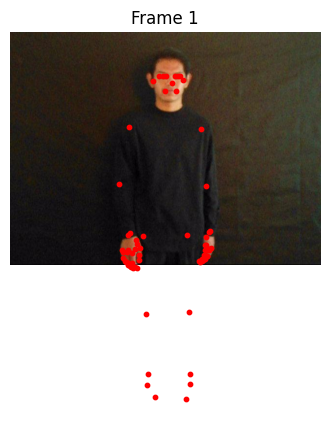

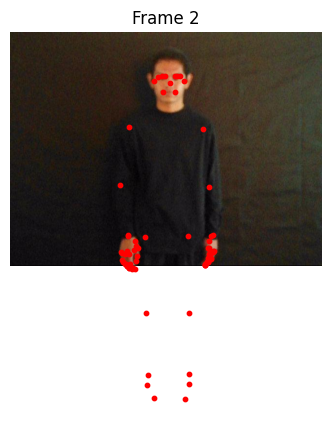

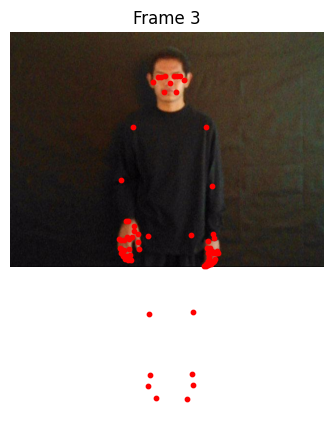

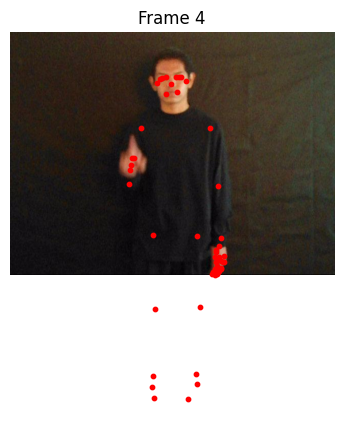

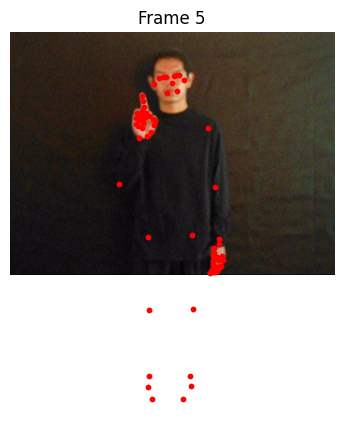

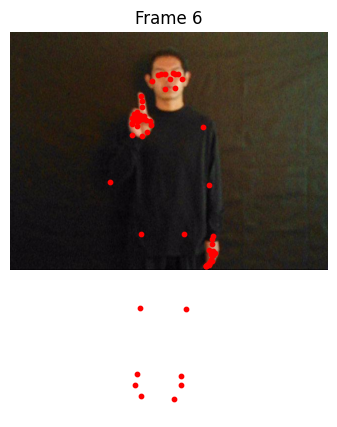

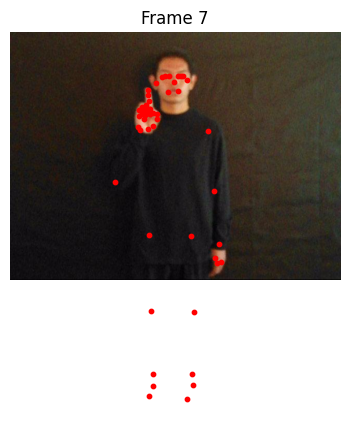

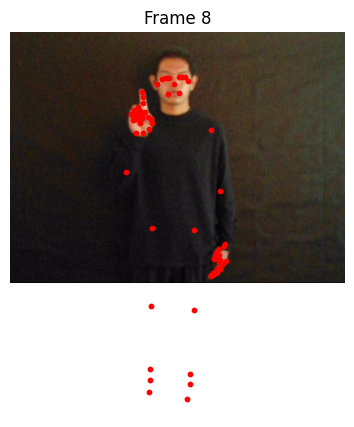

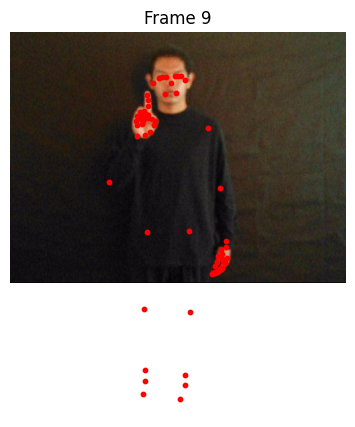

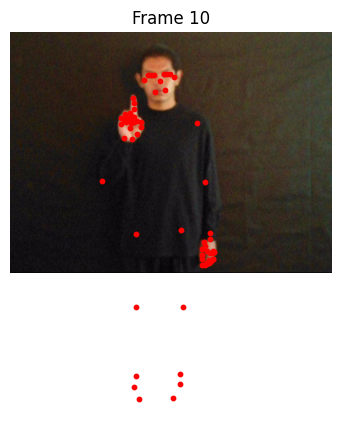

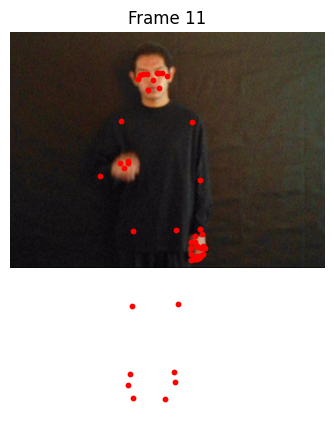

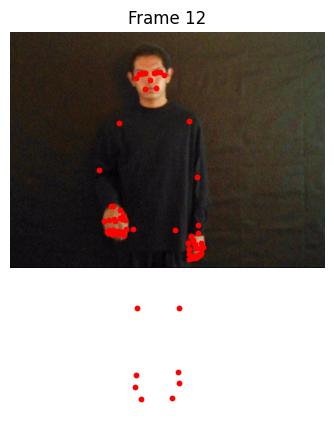

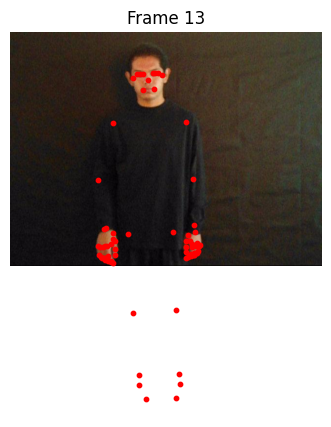

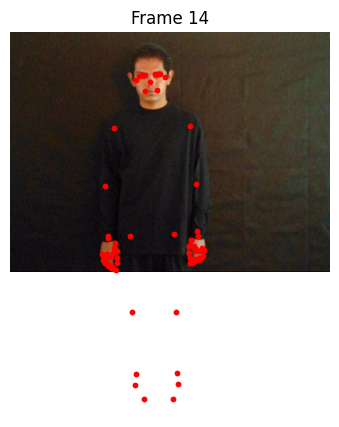

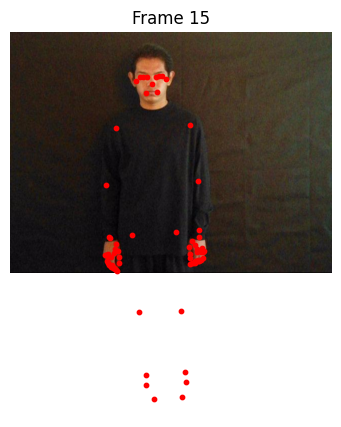

In [20]:
idx = 13  # ejemplo
sequence = X[idx]
label = y[idx]

inv_palabra2label = {v: k for k, v in palabra2label.items()}
palabra = inv_palabra2label[label]

print(f"Visualizando id {idx} de la palabra: {palabra}")
print(f"Shape de la secuencia: {sequence.shape}")

# Buscar fila para obtener path
variacion_row = subset_df[subset_df["palabra"] == palabra].iloc[0]
indice_str = str(variacion_row["indice_palabra"]).zfill(3)
variacion = variacion_row["variacion"]
variacion_path = os.path.join(palabras_path, indice_str, str(variacion))

# Ordenar frames
frames_list = sorted(
    [f for f in os.listdir(variacion_path) if f.lower().endswith((".jpg", ".png"))],
    key=lambda x: int(''.join(filter(str.isdigit, os.path.splitext(x)[0])))
)

# Forzar visualización de 15 frames equidistantes
num_frames = 15
if len(frames_list) >= num_frames:
    selected_indices = np.linspace(0, len(frames_list) - 1, num_frames, dtype=int)
    frames_to_show = [frames_list[i] for i in selected_indices]
else:
    # Si hay menos de 15 frames, repetir algunos para completar
    repeats = int(np.ceil(num_frames / len(frames_list)))
    frames_to_show = (frames_list * repeats)[:num_frames]

# Visualización
for i, frame_file in enumerate(frames_to_show):
    frame_path = os.path.join(variacion_path, frame_file)
    frame_orig = cv2.imread(frame_path)
    lm_orig = extract_landmarks(frame_orig)

    plt.figure(figsize=(10, 5))

    plt.imshow(cv2.cvtColor(frame_orig, cv2.COLOR_BGR2RGB))
    if lm_orig:
        n_points = len(lm_orig) // 3
        for j in range(n_points):
            x, y_coord = lm_orig[j * 3], lm_orig[j * 3 + 1]
            plt.scatter(x * frame_orig.shape[1], y_coord * frame_orig.shape[0], c='r', s=10)
    plt.title(f"Frame {i+1}")
    plt.axis('off')
    plt.show()

# **Conclusiones**

En esta fase se llevó a cabo la extracción y representación de características a partir de datos visuales del conjunto de lenguaje de señas mexicano (MSL). El objetivo fue transformar secuencias de imágenes crudas en representaciones numéricas significativas, aptas para su posterior uso en modelos de clasificación de gestos.

Para ello, se implementó un pipeline basado en MediaPipe, encargado de detectar y extraer landmarks corporales y manuales en cada frame de los videos correspondientes a las distintas palabras del dataset. Esta estrategia permitió convertir la información visual en vectores de coordenadas normalizadas (x, y, z), que describen la posición de cada punto clave del cuerpo y las manos. De esta manera, los frames dejaron de ser simples imágenes RGB y se transformaron en una descripción cuantitativa del gesto.

Además, se aplicó una homologación temporal mediante la normalización del número de frames por secuencia (15 en total). Esta decisión garantiza que todas las muestras tengan la misma longitud, permitiendo un procesamiento uniforme durante la fase de modelado. En los casos en que las secuencias eran más cortas, se aplicó padding para completar la longitud establecida.

La visualización de los frames mostró una detección consistente y precisa de los landmarks, con una distribución espacial coherente con la posición corporal real del sujeto. Esto confirma que la extracción de características fue exitosa y que los datos generados son representativos del gesto realizado en cada video.

Con esto, el dataset queda preparado para avanzar hacia las siguientes etapas de la metodología, como el entrenamiento de modelos supervisados que permitan clasificar gestos del lenguaje de señas mexicano de forma automatizada.